# Clustering de vehiculos

In [1]:
# Importo librerías
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt  
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# Defino una función para representar el dendograma
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    fig = plt.figure(figsize=(20,3))
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
# Cargo los datos
df = pd.read_csv("cars_clus.csv")

In [4]:
df

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,17.531,$null$,0.000,28.800,2.400,168.000,104.900,69.300,186.200,3.259,17.900,25.000,2.864,0.0
155,Volvo,C70,3.493,$null$,0.000,45.500,2.300,236.000,104.900,71.500,185.700,3.601,18.500,23.000,1.251,0.0
156,Volvo,S80,18.969,$null$,0.000,36.000,2.900,201.000,109.900,72.100,189.800,3.600,21.100,24.000,2.943,0.0
157,NaN,newCar,$null$,$null$,$null$,21.500,1.500,76.000,106.300,67.900,175.000,2.932,11.900,46.000,$null$,1.0


In [5]:
print("Forma del set de datos: ", df.shape)

Forma del set de datos:  (159, 16)


In [6]:
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [7]:
df.sales.value_counts()

$null$     2
1.112      1
42.643     1
88.094     1
79.853     1
          ..
155.787    1
125.338    1
220.650    1
540.561    1
26.232     1
Name: sales, Length: 158, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   157 non-null    object 
 1   model      159 non-null    object 
 2   sales      159 non-null    object 
 3   resale     159 non-null    object 
 4   type       159 non-null    object 
 5   price      159 non-null    object 
 6   engine_s   159 non-null    object 
 7   horsepow   159 non-null    object 
 8   wheelbas   159 non-null    object 
 9   width      159 non-null    object 
 10  length     159 non-null    object 
 11  curb_wgt   159 non-null    object 
 12  fuel_cap   159 non-null    object 
 13  mpg        159 non-null    object 
 14  lnsales    159 non-null    object 
 15  partition  159 non-null    float64
dtypes: float64(1), object(15)
memory usage: 20.0+ KB


In [9]:
df[[ 'sales', 'resale', 'type', 'price', 'engine_s',
     'horsepow', 'wheelbas', 'width', 'length', 
     'curb_wgt', 'fuel_cap', 'mpg', 'lnsales']] = df[['sales', 'resale', 'type', 
                                                      'price', 'engine_s',
                                                      'horsepow', 'wheelbas', 
                                                      'width', 'length', 
                                                      'curb_wgt', 'fuel_cap',
                                                      'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')

In [10]:
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,CL,14.114,18.225,0.0,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2.647,0.0
3,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
4,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   manufact   157 non-null    object 
 1   model      159 non-null    object 
 2   sales      157 non-null    float64
 3   resale     121 non-null    float64
 4   type       157 non-null    float64
 5   price      157 non-null    float64
 6   engine_s   158 non-null    float64
 7   horsepow   158 non-null    float64
 8   wheelbas   158 non-null    float64
 9   width      158 non-null    float64
 10  length     158 non-null    float64
 11  curb_wgt   157 non-null    float64
 12  fuel_cap   158 non-null    float64
 13  mpg        156 non-null    float64
 14  lnsales    157 non-null    float64
 15  partition  159 non-null    float64
dtypes: float64(14), object(2)
memory usage: 20.0+ KB


In [12]:
df = df.dropna()
df = df.reset_index(drop=True)
print ("Datos finales", df.shape)

Datos finales (117, 16)


In [13]:
df = pd.get_dummies(df, columns=['manufact'])

In [14]:
df = df.drop(["model"],  1)

C:\Users\pere_\AppData\Local\Temp\ipykernel_9976\4083445611.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(["model"],  1)


In [15]:
df.head()

,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,...,manufact_Mercury,manufact_Mitsubishi,manufact_Nissan,manufact_Oldsmobile,manufact_Plymouth,manufact_Pontiac,manufact_Porsche,manufact_Saturn,manufact_Toyota,manufact_Volkswagen
0,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,...,0,0,0,0,0,0,0,0,0,0
1,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,...,0,0,0,0,0,0,0,0,0,0
2,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,...,0,0,0,0,0,0,0,0,0,0
3,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,...,0,0,0,0,0,0,0,0,0,0
4,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df.columns

Index(['sales', 'resale', 'type', 'price', 'engine_s', 'horsepow', 'wheelbas',
       'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales',
       'partition', 'manufact_Acura', 'manufact_Audi', 'manufact_BMW',
       'manufact_Buick', 'manufact_Cadillac', 'manufact_Chevrolet',
       'manufact_Chrysler', 'manufact_Dodge', 'manufact_Ford',
       'manufact_Honda', 'manufact_Hyundai', 'manufact_Infiniti',
       'manufact_Jeep', 'manufact_Lexus', 'manufact_Lincoln',
       'manufact_Mercedes-Benz', 'manufact_Mercury', 'manufact_Mitsubishi',
       'manufact_Nissan', 'manufact_Oldsmobile', 'manufact_Plymouth',
       'manufact_Pontiac', 'manufact_Porsche', 'manufact_Saturn',
       'manufact_Toyota', 'manufact_Volkswagen'],
      dtype='object')

In [17]:
scaler = StandardScaler()
num_cols = ['sales', 'resale', 'type', 'price', 'engine_s', 'horsepow', 'wheelbas',
            'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'lnsales',
            'partition']

df[num_cols] = scaler.fit_transform(df[num_cols])

In [18]:
df.head()

,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,...,manufact_Mercury,manufact_Mitsubishi,manufact_Nissan,manufact_Oldsmobile,manufact_Plymouth,manufact_Pontiac,manufact_Porsche,manufact_Saturn,manufact_Toyota,manufact_Volkswagen
0,-0.564554,-0.144648,-0.57406,-0.317230,-1.188519,-0.707601,-0.764273,-1.106603,-1.110752,-1.152084,...,0,0,0,0,0,0,0,0,0,0
1,-0.263968,0.159525,-0.57406,0.172510,0.143989,0.749354,0.096494,-0.253125,0.375767,0.324491,...,0,0,0,0,0,0,0,0,0,0
2,-0.676024,1.011901,-0.57406,1.137795,0.429526,0.492244,0.907361,0.059816,0.644065,0.884513,...,0,0,0,0,0,0,0,0,0,0
3,-0.518017,0.365480,-0.57406,-0.140498,-1.188519,-0.536195,-0.589625,-0.850559,-0.704679,-0.548336,...,0,0,0,0,0,0,0,0,0,0
4,-0.539653,0.477976,-0.57406,0.566432,-0.236728,0.320838,0.171343,1.396931,0.310505,0.398488,...,0,0,0,0,0,0,0,0,0,0


In [43]:
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='complete', distance_threshold=0)
cluster.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='manhattan', distance_threshold=0,
                        linkage='complete', n_clusters=None)

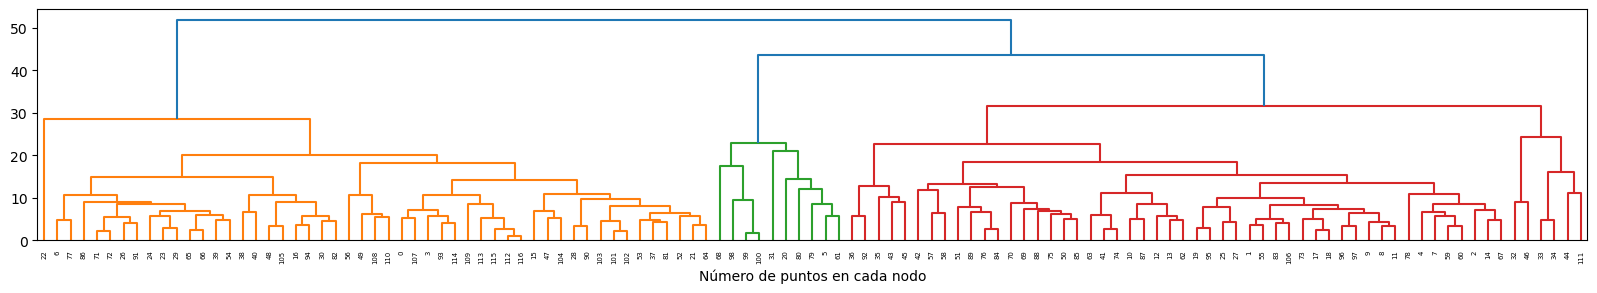

In [44]:
plot_dendrogram(cluster, truncate_mode='level')
plt.xlabel(u"Número de puntos en cada nodo")
plt.show()

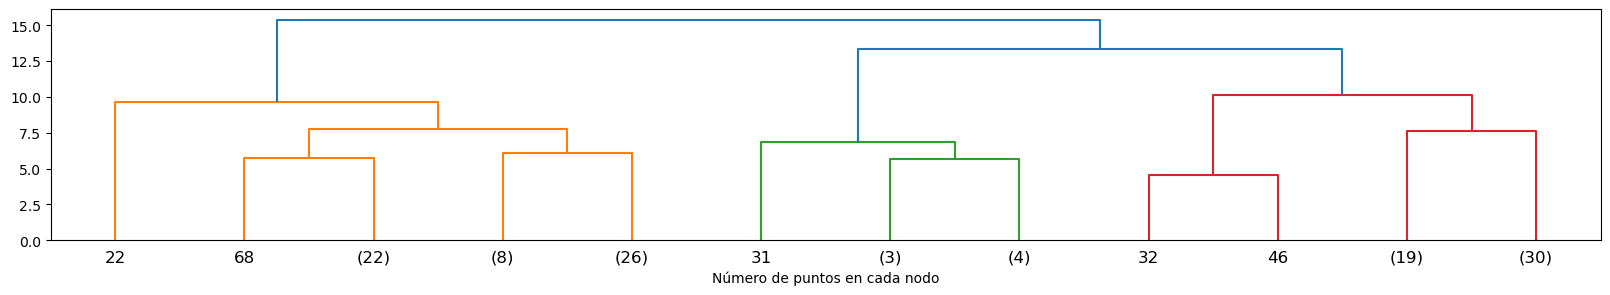

In [21]:
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.xlabel(u"Número de puntos en cada nodo")
plt.show()

In [22]:
# Fuerzo a que haya 3 clústers
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete', distance_threshold=None)
cluster.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=3)

In [23]:
cluster.labels_

array([1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [24]:
df

,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,...,manufact_Mercury,manufact_Mitsubishi,manufact_Nissan,manufact_Oldsmobile,manufact_Plymouth,manufact_Pontiac,manufact_Porsche,manufact_Saturn,manufact_Toyota,manufact_Volkswagen
0,-0.564554,-0.144648,-0.57406,-0.317230,-1.188519,-0.707601,-0.764273,-1.106603,-1.110752,-1.152084,...,0,0,0,0,0,0,0,0,0,0
1,-0.263968,0.159525,-0.57406,0.172510,0.143989,0.749354,0.096494,-0.253125,0.375767,0.324491,...,0,0,0,0,0,0,0,0,0,0
2,-0.676024,1.011901,-0.57406,1.137795,0.429526,0.492244,0.907361,0.059816,0.644065,0.884513,...,0,0,0,0,0,0,0,0,0,0
3,-0.518017,0.365480,-0.57406,-0.140498,-1.188519,-0.536195,-0.589625,-0.850559,-0.704679,-0.548336,...,0,0,0,0,0,0,0,0,0,0
4,-0.539653,0.477976,-0.57406,0.566432,-0.236728,0.320838,0.171343,1.396931,0.310505,0.398488,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.660329,-0.571701,-0.57406,-0.785677,-0.998161,-1.136117,-1.051195,-0.822110,-1.770621,-0.936820,...,0,0,0,0,0,0,0,0,0,1
113,0.329268,-0.414639,-0.57406,-0.657919,-0.998161,-1.136117,-1.051195,-0.822110,-1.118003,-0.792190,...,0,0,0,0,0,0,0,0,0,1
114,-0.107179,-0.113062,-0.57406,-0.338523,-1.188519,-0.536195,-0.115579,-0.765212,-0.262349,-0.472658,...,0,0,0,0,0,0,0,0,0,1
115,-0.662898,-0.126043,-0.57406,-0.424405,-0.998161,-1.136117,-1.238318,-1.277298,-1.980909,-0.412115,...,0,0,0,0,0,0,0,0,0,1


In [25]:
X = pd.read_csv("cars_clus.csv")

X[[ 'sales', 'resale', 'type', 'price', 'engine_s',
     'horsepow', 'wheelbas', 'width', 'length', 
     'curb_wgt', 'fuel_cap', 'mpg', 'lnsales']] = X[['sales', 'resale', 'type', 
                                                      'price', 'engine_s',
                                                      'horsepow', 'wheelbas', 
                                                      'width', 'length', 
                                                      'curb_wgt', 'fuel_cap',
                                                      'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')

X = X.dropna()
X = X.reset_index(drop=True)
print ("Datos finales", X.shape)

Datos finales (117, 16)


In [26]:
X["asignacion_cluster"] = cluster.labels_

In [27]:
X[(X["asignacion_cluster"] == 0)].describe()

,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,asignacion_cluster
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0,51.0
mean,71.395902,16.552157,0.490196,26.551784,3.625490,199.156863,112.441176,73.433333,197.364706,3.779020,20.201961,21.686275,3.751608,0.0,0.0
std,90.726488,4.470790,0.504878,7.352714,0.694793,35.266059,7.856696,3.311837,11.549179,0.413795,3.589345,3.062615,1.004629,0.0,0.0
min,5.711000,7.850000,0.000000,12.050000,2.400000,119.000000,101.100000,66.500000,167.500000,3.086000,16.000000,15.000000,1.742000,0.0,0.0
25%,22.046500,13.575000,0.000000,21.820000,3.050000,175.000000,107.450000,70.350000,191.300000,3.472000,17.750000,19.000000,3.090500,0.0,0.0
50%,39.350000,15.380000,0.000000,25.345000,3.500000,200.000000,111.600000,73.000000,196.200000,3.770000,19.000000,22.000000,3.672000,0.0,0.0
75%,80.865000,19.457500,1.000000,29.382000,4.000000,217.500000,114.250000,75.550000,205.000000,3.962500,21.000000,24.000000,4.393000,0.0,0.0
max,540.561000,34.080000,1.000000,51.728000,5.200000,275.000000,138.700000,79.300000,224.500000,5.115000,32.000000,27.000000,6.293000,0.0,0.0


In [28]:
X["asignacion_cluster"].value_counts()

1    58
0    51
2     8
Name: asignacion_cluster, dtype: int64

In [29]:
import seaborn as sns

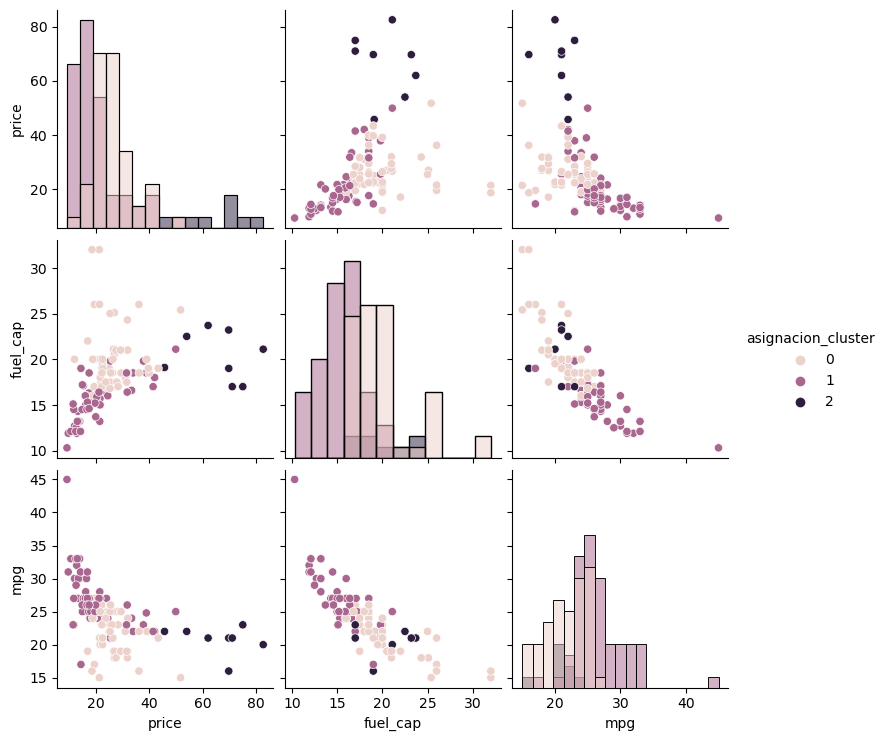

In [30]:
sns.pairplot(data=X, 
             hue="asignacion_cluster", 
             vars= ["price", "fuel_cap", "mpg"],
             diag_kind="hist")
plt.show()

## Probamos otra clusterización

In [31]:
# Fuerzo a que haya 3 clústers
cluster_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward', distance_threshold=None)
cluster_ward.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [32]:
X["asignacion_cluster_ward"] = cluster_ward.labels_

In [33]:
X["asignacion_cluster_ward"].value_counts()

1    51
0    43
2    23
Name: asignacion_cluster_ward, dtype: int64

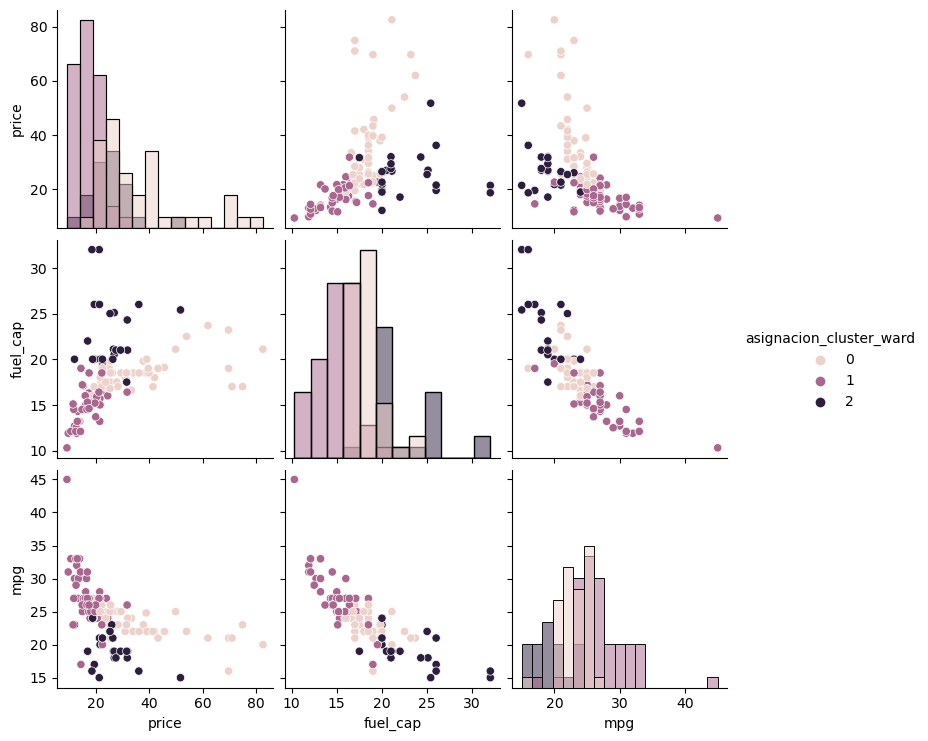

In [34]:
sns.pairplot(data=X, 
             hue="asignacion_cluster_ward", 
             vars= ["price", "fuel_cap", "mpg"],
             diag_kind="hist")
plt.show()

# Ejercicio en clase.

- Prueba los otros métodos del parámetro `linkage` __single__ y __average__
- Toma la misma clusterización realizada con el parámetro  `linkage` __ward__, pero, en este caso, en el parámetro `affinity` prueba la distancia Manhattan, posteriormente, tras segementar los datos, observa los datos promedios de las segmentaciones ¿Qué diferencias observas?

In [45]:
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='single', distance_threshold=0)
cluster.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        linkage='single', n_clusters=None)

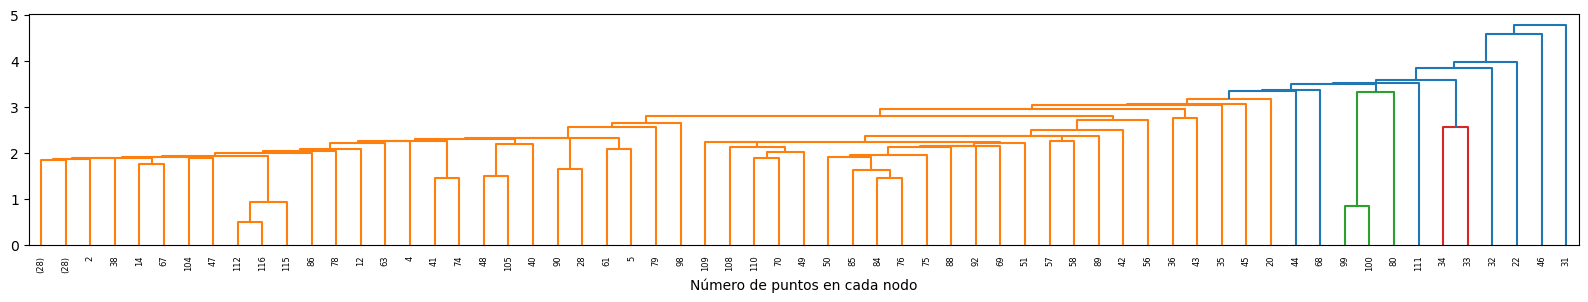

In [46]:
plot_dendrogram(cluster, truncate_mode='level')
plt.xlabel(u"Número de puntos en cada nodo")
plt.show()

In [49]:
cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='average', distance_threshold=0)
cluster.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        linkage='average', n_clusters=None)

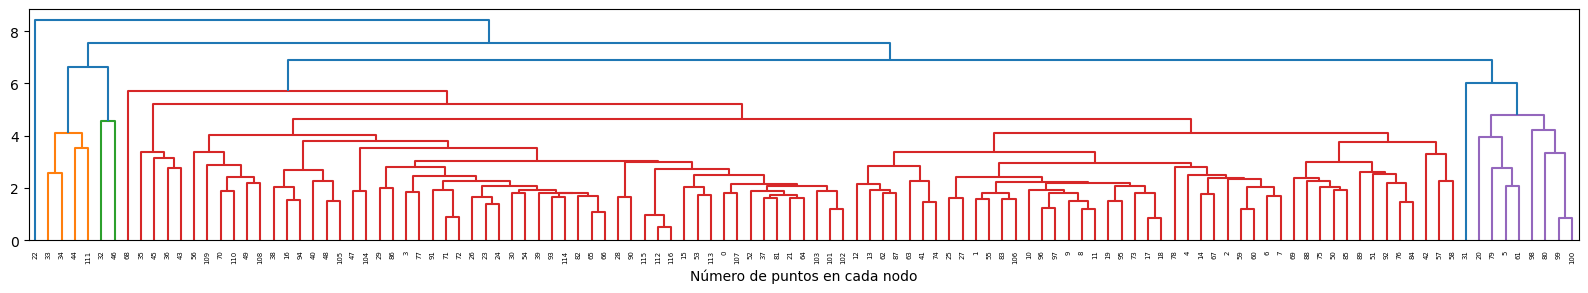

In [50]:
plot_dendrogram(cluster, truncate_mode='level')
plt.xlabel(u"Número de puntos en cada nodo")
plt.show()

In [47]:
cluster = AgglomerativeClustering(n_clusters=None, affinity='manhattan', linkage='complete', distance_threshold=0)
cluster.fit(df)

C:\Users\pere_\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='manhattan', distance_threshold=0,
                        linkage='complete', n_clusters=None)

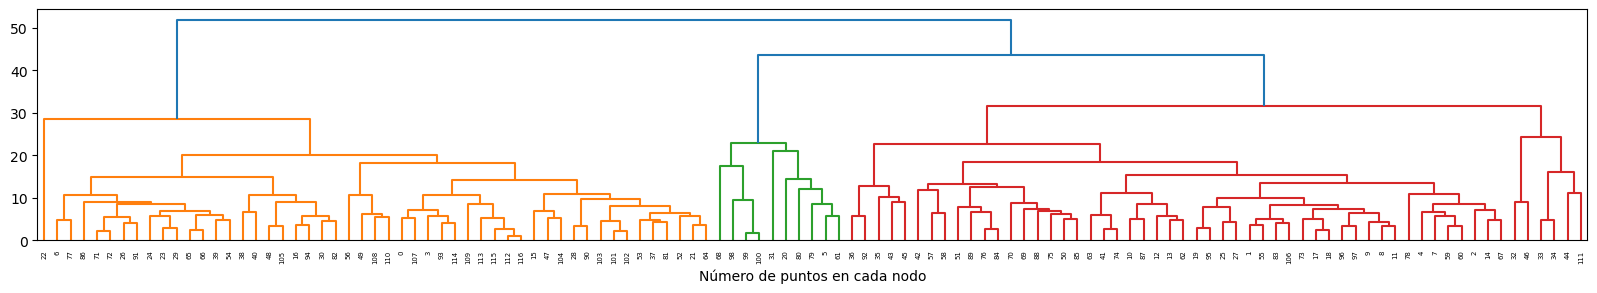

In [48]:
plot_dendrogram(cluster, truncate_mode='level')
plt.xlabel(u"Número de puntos en cada nodo")
plt.show()